# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 6. Основы обработки текстов


In [3]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 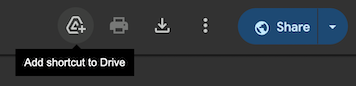

Скачаем данные для обучения и тестирования:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/My-Drive/Data_science"

ls: cannot access '/content/drive/My-Drive/Data_science': No such file or directory


In [6]:
dataset = pd.read_csv("drive/MyDrive/Data_science/salary_dataset.csv")
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [7]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Разделим датасет на `train` и `test`. Далее предобработку текста будем делать для обучающих данных.

In [8]:
train, test = train_test_split(dataset, test_size=0.2, shuffle=True)

In [9]:
train.FullDescription

145363    Business Development Manager / Sales Executive...
109208    Our client is seeking a Vendor Account Executi...
47584     Happy New Year from Protocol Education Leicest...
4143      Infrastructure Support Engineer Preston based ...
159730    Automotive Bodyshop Technician Required in the...
                                ...                        
192946    STAFFFINDERS are looking for cooks to fill a n...
11184     Dental Nurse (RDN), Barnet, Hertfordshire, Par...
188766    Oracle Business Support Analyst  Oracle We hav...
63005     We are currently recruiting for an experienced...
28348     My client, a rapidly expanding London restaura...
Name: FullDescription, Length: 160000, dtype: object

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [10]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовим словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудем предварительно убрать из предложений знаки пунктуации и стоп-слова.

Можем написать фунцкии, которые исключат не нужные слова из массива текстов. Но можно поступить по-другому: заведем счетчик, который будет искать самые частые слова, отсекая ненужные. Внтури него мы наложим ограничения на слова. Тем самым мы как бы отсекаем стоп-слова и пунктуацию.

In [11]:
# уберем из предложений знаки пунктуации и стоп-слова
def remove_punctuation(text, punctuation):
  return ''.join([ch for ch in text if ch not in punctuation])

def remove_stopwords(text, stopwords):
  return [word for word in text if word not in stopwords]

In [12]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in train.FullDescription:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [13]:
list(ordered_dict.items())[:10]

[(' ', 532491),
 ('experience', 215743),
 ('The', 206968),
 ('role', 168959),
 ('work', 166101),
 ('team', 155641),
 ('This', 144103),
 ('within', 139893),
 ('You', 139483),
 ('skills', 130056)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [14]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [15]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target, smart_pad_collate=False):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) target (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

        if smart_pad_collate:
          self.texts.sort(key=len)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Напишем функцию для дополнения текста до максимальной длины в батче.

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

Есть два основных подхода к паддингу последовательностей:
1. сэмплируем батч и после этого дополняем паддингом последовательности до максимальной длины в батче.
2. сэмплы приблизительно одинаковой длины группируем в отдельный бакет, а батч примеров сэмплируется из одного бакета.

In [16]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t) for t in texts]  # мб надо FloatTensor
    target = torch.FloatTensor(np.array(target))

    # дополним до макс. длины в батче
    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [ ]:
train_tokens = [vocab(tokenizer(text)) for text in train["FullDescription"]]
train_targets = [float(value) for value in train["SalaryNormalized"]]

# дополнительно выделим из train датасет valid
train_tokens, valid_tokens, train_targets, valid_targets = train_test_split(
    train_tokens, train_targets
)
valid_tokens, test_tokens, valid_target, test_target = train_test_split(
    valid_tokens, valid_targets
)

In [18]:
num_tokens = len(vocab)
num_tokens

25002

Посмотрим на распределение количества токенов в тексте.

Максимальная длина: 2179


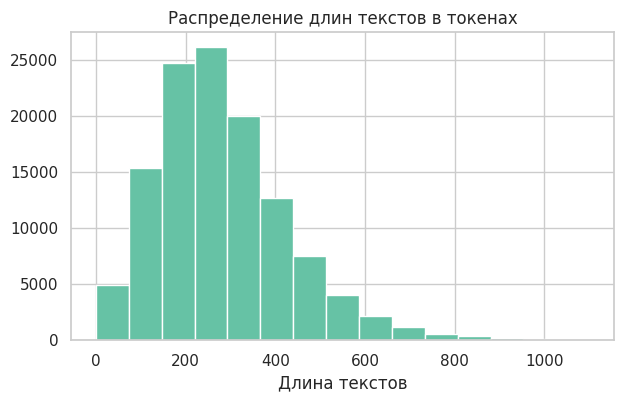

In [19]:
lens = [len(row) for row in train_tokens]
print("Максимальная длина:", max(lens))

plt.figure(figsize=(7, 4))
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Длина текстов")
plt.hist(lens, bins=15, range=(0, 1100))
plt.show();

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [20]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(train_tokens[i])}:\n  ", end="")
    for token in train_tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", train_targets[i], "\n")

Количество токенов в 0-м тексте - 69:
  95, 172, 1350, 25000, 69, 25000, 25000, 25000, 25000, 25000, ...
Таргет: 30000.0 

Количество токенов в 1-м тексте - 232:
  1211, 452, 653, 25000, 274, 163, 25000, 469, 29, 195, ...
Таргет: 32500.0 

Количество токенов в 2-м тексте - 313:
  29, 9134, 32, 113, 2125, 25000, 2648, 25000, 416, 1594, ...
Таргет: 32000.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`.
Таким образом, мы получим значения, удобные для использования при обучении.

In [21]:
scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_targets).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_targets).reshape(-1, 1))
test_target_std = scaler.transform(np.array(test_targets).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
test_data = SalaryPredictionDataset(test_tokens, valid_target_std)

len(train_data), len(valid_data), len(test_data)

(120000, 40000)

Посмотрим на отмасштабированные значения зарплаты:

In [22]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.1282, 0.141, 0.1385, ...


Сформируем даталоадеры для обучения и валидации.

In [23]:
BATCH_SIZE = 64 # размер батча

train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)
valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)
test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)


## Архитектура рекуррентной нейронной сети

Наконец, можем подготовить модель.
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет.

In [24]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        num_layers = 1,
        output_dim=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True, num_layers=num_layers)
        self.classifier = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """

        # получим эмбеддинги для входов
        # (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)

        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, num_tokens)
        predictions = self.classifier(h_state.squeeze(0))
        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [74]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Напишем функции для обучения и валидации.

In [75]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        optimizer.zero_grad()
        #получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels.float())
        temp_mse = mse(predictions, labels)

        # сделаем back-propagation для подсчета градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += temp_mse.item()
        train_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels.float())
            temp_mse = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += temp_mse.item()
            if val_loss_history is not None:
              val_loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [76]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

Обучим несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравним их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

**Модель 1**

In [33]:
# Задаем параметры сети
model1 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=256,
    rnn_num_units=8,
    num_layers=3,
    output_dim=1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.005)
history = []

model1

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 8, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

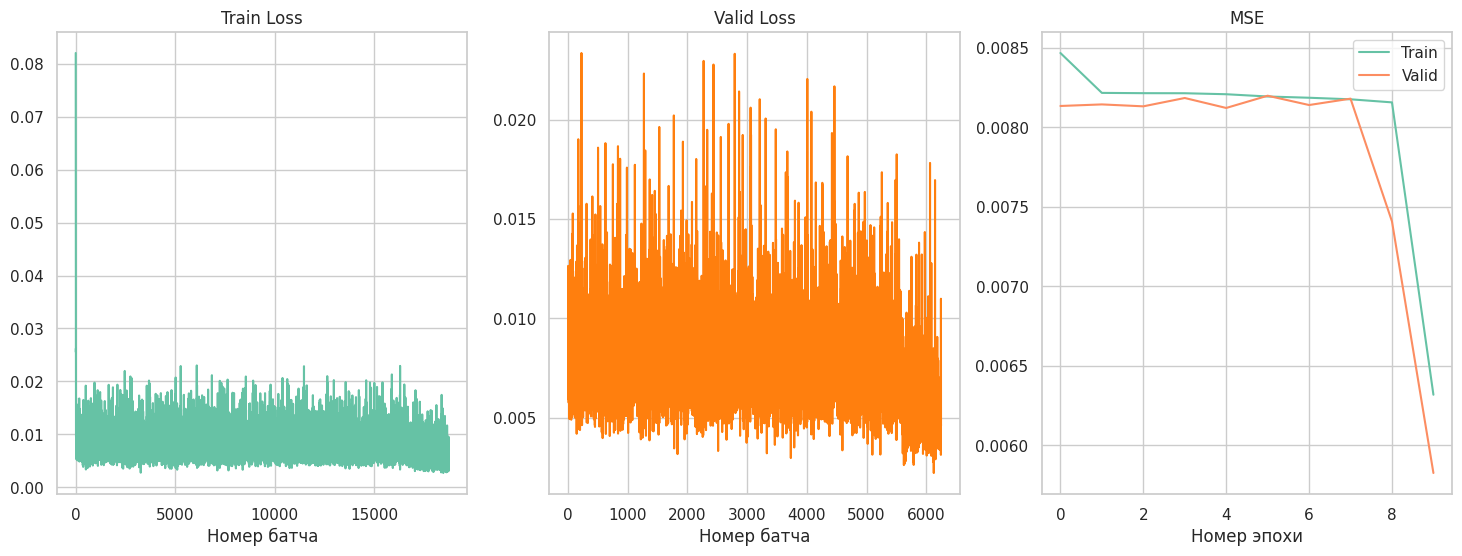

Номер эпохи: 10 | Время обучения эпохи: 0m 28s


In [34]:
training_loop(model1)

Видим, что только к 10-ой эпохе стало наблюдаться уменьшение ошибки модели. Чтобы преодолеть "плато" увеличим количество эпох.

**Модель 2**.
- $n\_epochs=10 → n\_epochs=20$
- $lr = 0.005 → lr = 0.01$

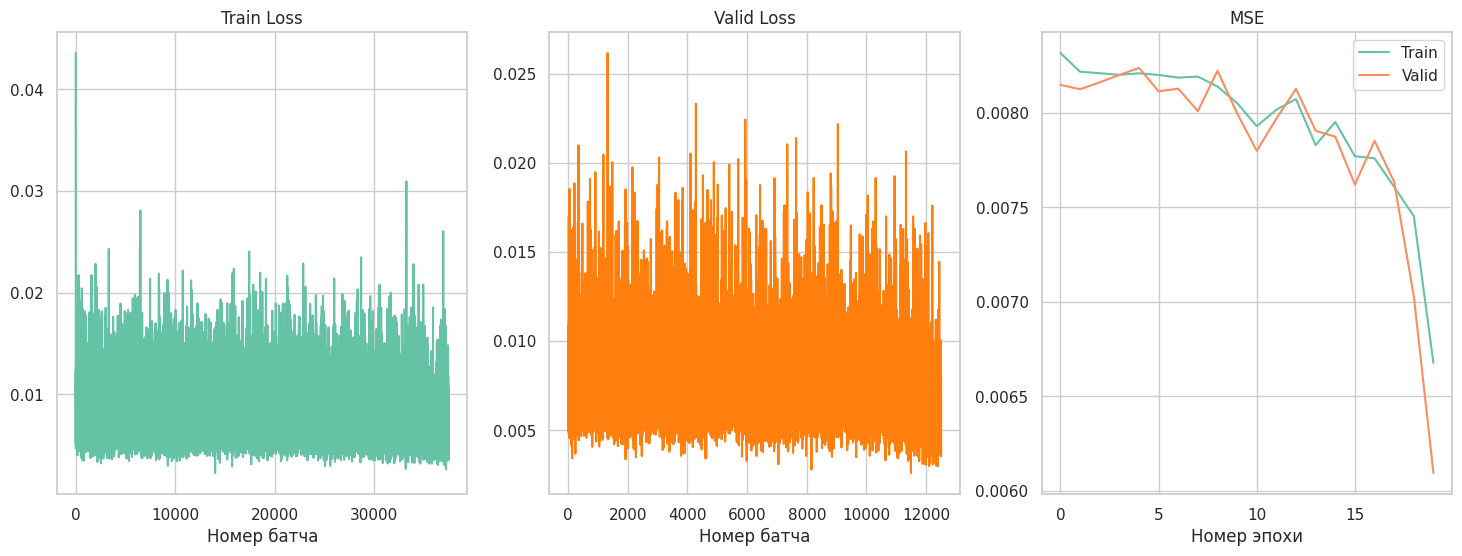

Номер эпохи: 20 | Время обучения эпохи: 0m 30s


In [35]:
# Задайте параметры сети
model2 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=256,
    rnn_num_units=8,
    num_layers=3,
    output_dim=1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.005)
history2 = []

training_loop(model2, n_epochs=20)

**Модель 3**
- $emb\_size = 256 → emp\_size = 512$
- $lr = 0.005 → lr = 0.01$
- $rnn\_num\_units=8 → rnn\_num\_units=4$, уменьшаем количество скрытых слоев.
- $n\_epochs = 15$

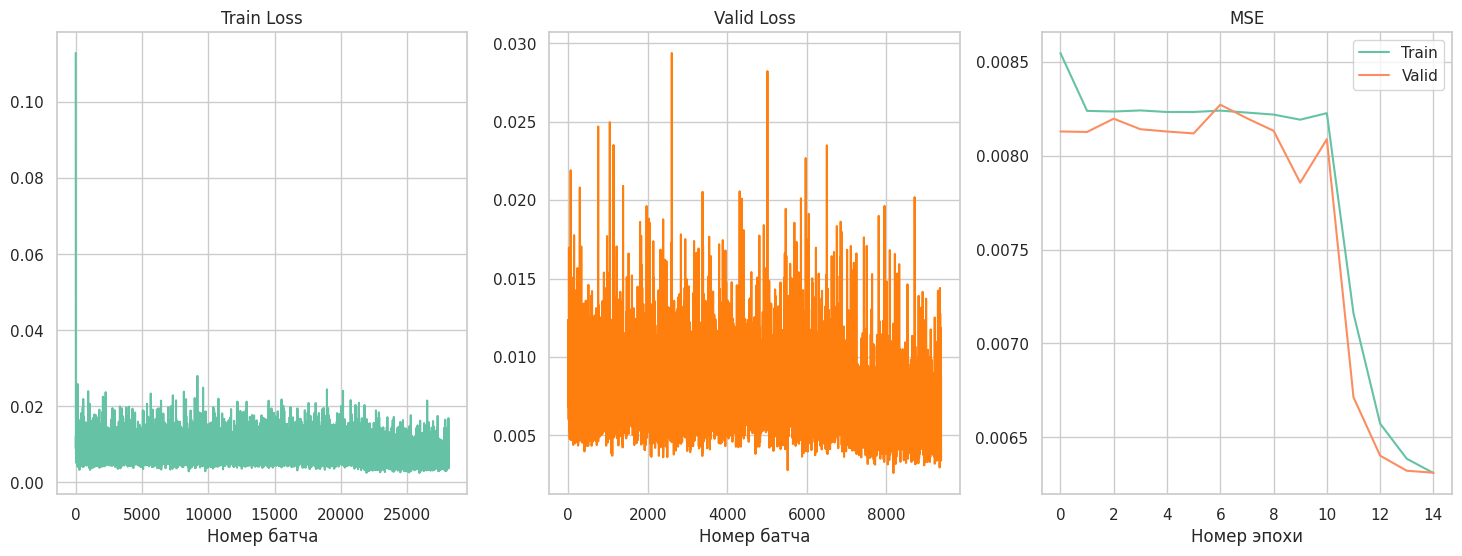

Номер эпохи: 15 | Время обучения эпохи: 0m 38s


In [36]:
# Задайте параметры сети
model3 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=512,
    rnn_num_units=4,
    num_layers=3,
    output_dim=1
).to(device)

# Увеличим learning rate и количество эпох.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)
history3 = []

# Посмотрите на получившуюся модель
training_loop(model3, n_epochs=15)

Выведем несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитаем MSE на всей тестовой выборке.

Возьмем 1 батч из тестовой выборки.

In [64]:
# Выведем предсказания для 5 случайных примера из тестового батча
indices = torch.randint(low=0, high=len(text), size=(5,)).numpy()
print(indices)

with torch.no_grad():
  for i in indices:
    text, label = dataset.loc[i]
    tokens = vocab(tokenizer(text))
    tokens = [
        token
        for token in tokens
        if token not in ["<unk>", "<pad>"]
    ]
    tokens = torch.LongTensor(tokens).to(device)
    print("=" * 40)
    print("Text:", text[:200])

    temp_pred = model3(tokens).squeeze(1)
    predict = scaler.inverse_transform(temp_pred.cpu().data.numpy()[-1].reshape(-1, 1))
    print(f"Предсказание: {predict.item()}")
    print(f"Истинное значение: {label}")
    print()


[572 397 433 782 106]
Text: Continued expansion mean our client is looking for a number of experienced wood pole lines workers. Ideally with authorisations for SP / Manweb or ENW , you will certainly have spent many years on DNO
Предсказание: 27399.78515625
Истинное значение: 37500

Text: Degree/HND/HNC Qualified Production Engineer sought by 30m turnover manufacturing business whose manufacturing processes include: aluminium extrusion, injection moulding, pressings, castings and joini
Предсказание: 29462.921875
Истинное значение: 30000

Text: Urgent Demi Chef De Partie Stamford Lincolnshire upto ****K Plus Tips and Live in Demi Chef or Chef de Partie required for this superb restaurant with rooms located between Stamford and Oakham. The ve
Предсказание: 21603.568359375
Истинное значение: 15000

Text: Capita Education Resourcing is one of the largest supply agencies in the UK supplying teachers to schools. Leicester's Branch is thriving, having just had its busiest year in 5 years We a

Посчитаем MSE:

In [77]:
mse1 = evaluate(model1, valid_loader, criterion)[0]
print(f"MSE = {mse1}")

<ipython-input-74-f794f5d76a43>:10: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([3, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(preds, y, reduction="mean")


MSE = 0.0058294282384216784


**Вывод:**
В этой работе мы научились применять `RNN` для предсказания зарплаты по описанию. Исследовав несколько моделей, мы поняли, что
 - увеличение количества скрытых слоев не всегда приводит к улучшению предсказаний модели
 - главной задачей для получения хорошего результата является правильный подбор параметров модели.
 - эмбединг так же влияет на предсказательную способность модели. Чем больше этот показатель, тем лучше модель справляется с обработкой и интерпретацией текста.
 - оптимальное количество эпох находится в диапазоне $(10, 20)$. Могу предположить, что слишком долгое обучение может привести к переобучению.